In [1]:
from functions import *
from random import sample
from htmldate import find_date
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
import json
from langid.langid import LanguageIdentifier, model
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl

%matplotlib inline

In [2]:
base_path = "/media/ruben/Data Drive/react-data/protest/carlo-batch-selection"
#base_path = "D:/react-data/protest/carlo-batch"

In [4]:

dates_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

ids_ = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    
    folders = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
    
    for f in folders:
        fn = os.path.join(photo_folder, f, "txt","parsed_text.json")

        with open(fn) as fp:
            file = json.load(fp)
        
        for id_ in file.keys():
            
            identif = id_.split("html_")[0].split('html/')[-1][:-1]
            url = id_.split("html_")[1]
            ids_.update({url:identif})

In [5]:
# Open translation file
refdf = pd.read_csv("/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/descriptive-full.csv")
refdf_title = dict(zip(refdf['image'],refdf['pretty_title']))
#refdf_country = dict(zip(refdf['pretty_title'],refdf['country']))

In [25]:
d_ = []
for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    
    with open(os.path.join(photo_folder,'languages-'+photo+".json"),'r') as f:
        lang = json.load(f)
    
    languages = []
    
    for iterkey,items1 in lang.items():
        
        for id_, lan_items in items1.items():
            
            if id_ in dates_ref.keys():
                date = dates_ref[id_]
                language = lan_items[0]
                
                d_.append([refdf_title[int(photo)],language,date[0:4],1])
            

In [95]:
d = pd.DataFrame(d_,columns=['photo','lan','date','count'])
d = d[['lan','date','count']]
d = d.groupby(['lan','date']).sum().reset_index()
df = d.pivot(index='date',columns='lan',values='count').fillna(0).reset_index()

In [96]:
lan_counts = [[c,int(df[c].sum())] for c in list(df.columns)[1:]]
lan_sel = [[l,c] for l,c in lan_counts if c > 100]
other_lan = [l[0] for l in lan_counts if l[0] not in [x[0] for x in lan_sel]]

In [97]:
#df['country'] = [refdf_country[c] for c in df.index]
#dfs = df.groupby('country').sum()#.reset_index()
dfs = df
dfs['other'] = dfs[other_lan].sum(axis=1)
dfs = dfs[['date']+ [i[0] for i in lan_sel] + ['other']]

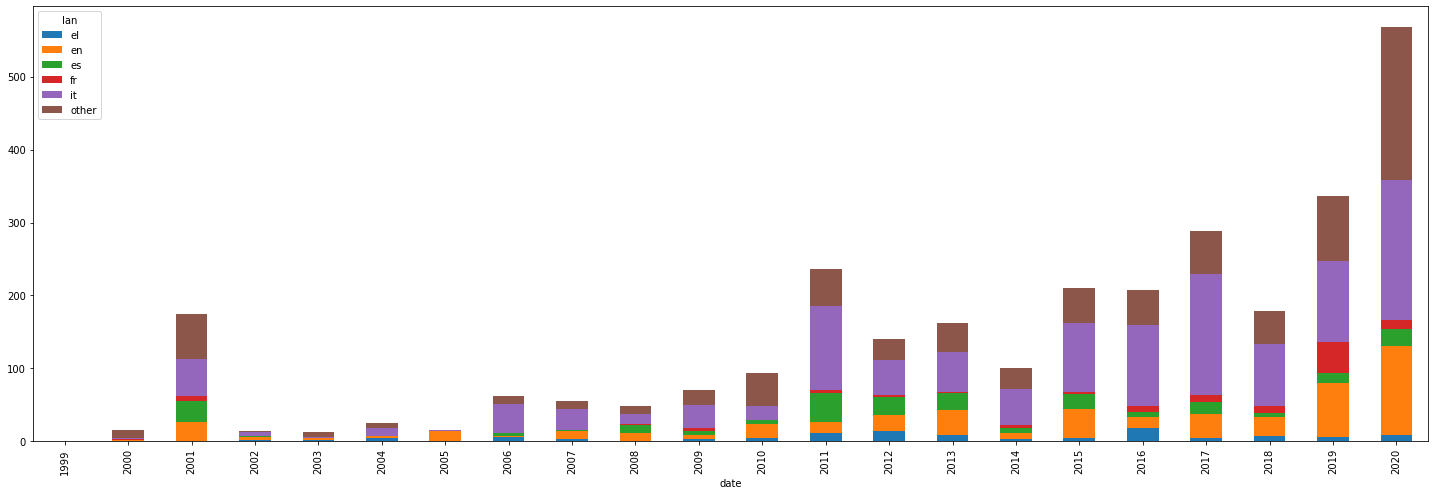

In [88]:
dfs.plot.bar(x='date',y=list(dfs.columns)[1:],stacked=True,figsize=(25,8))

In [98]:
dfsr = dfs.T.reset_index()
dfsr.columns = dfsr.iloc[0,:]
dfsr = dfsr.iloc[1:,:]

In [99]:
dfsr

,date,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,el,0,0,0,2,2,4,0,6,3,...,11,14,8,3,5,18,4,7,6,8
2,en,0,2,27,4,3,3,14,1,11,...,16,22,35,8,39,16,33,26,74,123
3,es,1,0,28,1,0,0,0,4,1,...,39,25,23,7,21,6,17,6,13,23
4,fr,0,1,7,0,0,0,0,1,0,...,4,3,2,4,3,9,10,10,43,12
5,it,0,1,51,6,1,11,1,39,29,...,115,48,55,50,94,110,165,84,111,192
6,other,0,11,62,1,7,7,0,11,11,...,51,28,39,29,48,48,60,46,90,210


In [140]:
dfsr2 = pd.DataFrame()
dfsr2['date'] = dfsr['date']

In [141]:
for i in list(dfsr.columns)[1:]:
    co = pd.DataFrame([x / dfsr[i].sum() * 100 for x in dfsr[i]])
    dfsr2[i] = co
    
dfsr2 = dfsr2.fillna(0)

In [148]:
dfsr2 = dfsr2.T.reset_index()
dfsr2.columns = dfsr2.iloc[0,:]
dfsr2 = dfsr2.iloc[1:,:]

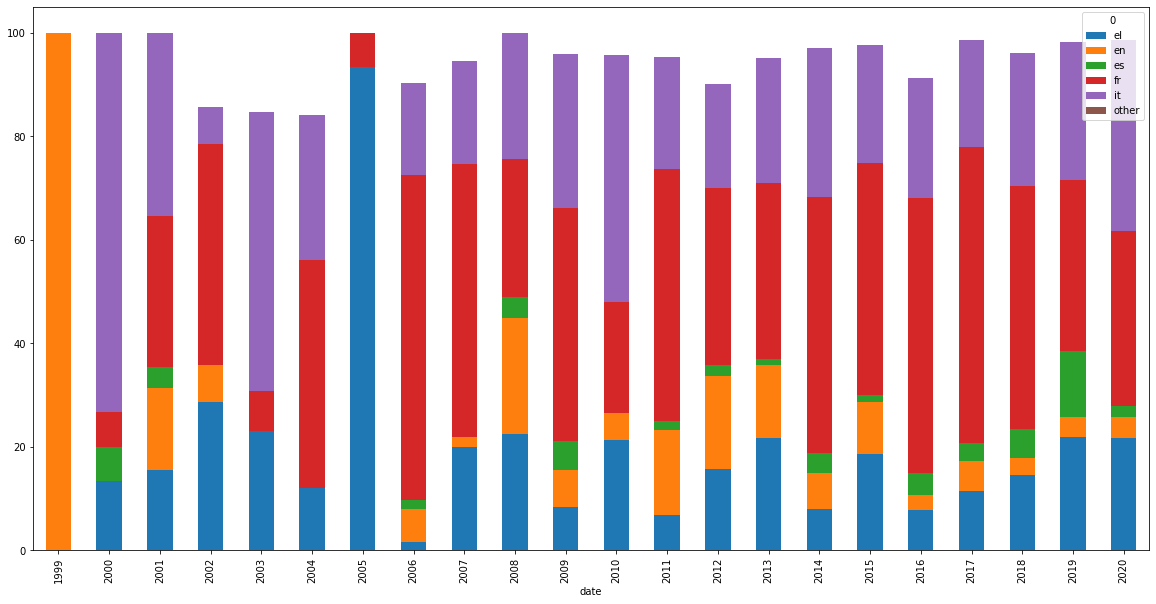

In [152]:
dfsr2.plot.bar(x='date',y=list(dfsr2.columns)[1:],stacked=True,figsize=(20,10))